### Classification for mushroom types

##### Practice with classifiers

In [1]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style

from kmodes.kmodes import KModes
#from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from plotly import graph_objects as go

from scipy.stats import chi2_contingency
from scipy.stats import chi2
from tqdm import tqdm

from dython.nominal import associations

from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\zazue\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\zazue\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from sklearn.tree import DecisionTreeClassifier
#from dython.model_utils import roc_graph
import shap

In [3]:
df = pd.read_csv('mushroom_data_raw.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Recommend dropping cap-shape = c & s, cap-surface = g, cap-color = r & u, odor = m


In [4]:
df['cap-shape'].unique()

array(['x', 'b', 's', 'f', 'k', 'c'], dtype=object)

In [5]:
for i in df.columns:
    print(i)
    for j in df[i].unique():
        print(j)
        print(df[df[i] == j]['class'].value_counts())

class
p
p    3916
Name: class, dtype: int64
e
e    4208
Name: class, dtype: int64
cap-shape
x
e    1948
p    1708
Name: class, dtype: int64
b
e    404
p     48
Name: class, dtype: int64
s
e    32
Name: class, dtype: int64
f
e    1596
p    1556
Name: class, dtype: int64
k
p    600
e    228
Name: class, dtype: int64
c
p    4
Name: class, dtype: int64
cap-surface
s
p    1412
e    1144
Name: class, dtype: int64
y
p    1740
e    1504
Name: class, dtype: int64
f
e    1560
p     760
Name: class, dtype: int64
g
p    4
Name: class, dtype: int64
cap-color
n
e    1264
p    1020
Name: class, dtype: int64
y
p    672
e    400
Name: class, dtype: int64
w
e    720
p    320
Name: class, dtype: int64
g
e    1032
p     808
Name: class, dtype: int64
e
p    876
e    624
Name: class, dtype: int64
p
p    88
e    56
Name: class, dtype: int64
b
p    120
e     48
Name: class, dtype: int64
u
e    16
Name: class, dtype: int64
c
e    32
p    12
Name: class, dtype: int64
r
e    16
Name: class, dtype: int64
bruises


In [6]:
df[df['stalk-surface-above-ring'] == 'y']['class']

6912    p
6967    e
6970    e
6984    e
7195    e
7292    e
7295    p
7367    p
7401    p
7449    e
7483    p
7533    e
7570    e
7600    p
7702    e
7706    p
7717    e
7739    p
7779    e
7887    e
7931    e
7984    e
7986    e
8001    e
Name: class, dtype: object

In [7]:
for i in df.columns:
    print(df[i].value_counts())

e    4208
p    3916
Name: class, dtype: int64
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64
y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
r      16
u      16
Name: cap-color, dtype: int64
f    4748
t    3376
Name: bruises, dtype: int64
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64
f    7914
a     210
Name: gill-attachment, dtype: int64
c    6812
w    1312
Name: gill-spacing, dtype: int64
b    5612
n    2512
Name: gill-size, dtype: int64
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, dtype: int64
t    4608
e    3516
Name: stalk-shape, dtype: int64
b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64
s    5176
k    2372
f     552
y      24
Name: stalk-surf

In [8]:
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [9]:
data_corr = df.copy()

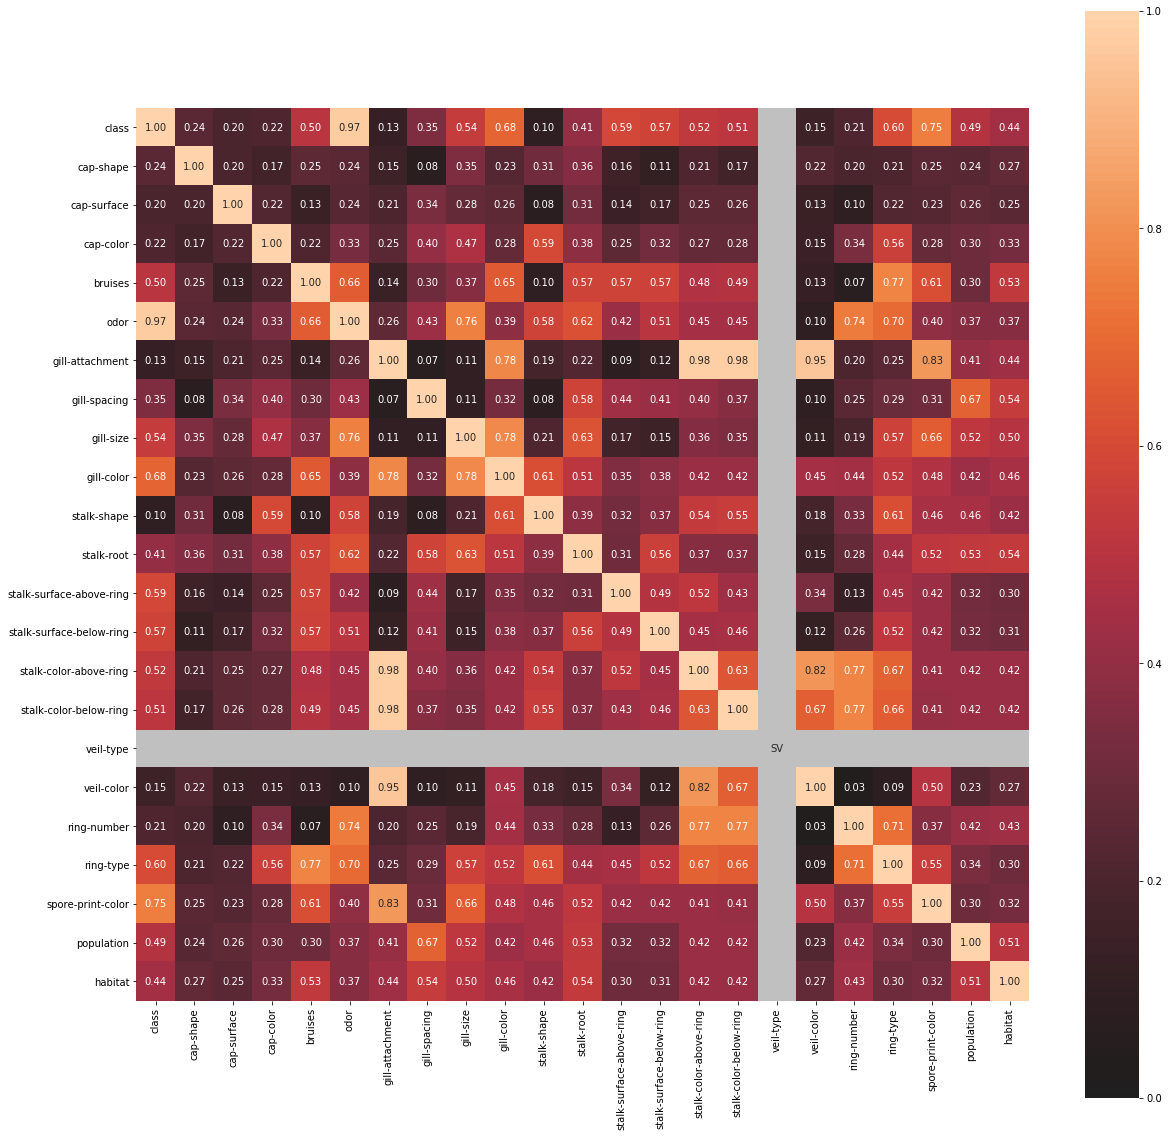

In [10]:
def associations_():
    associations(data_corr,nominal_columns=['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                                            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                                            'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                                            'stalk-surface-below-ring', 'stalk-color-above-ring',
                                            'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                                            'ring-type', 'spore-print-color', 'population', 'habitat'])

plt.rcParams["figure.figsize"]=20,20
associations_()

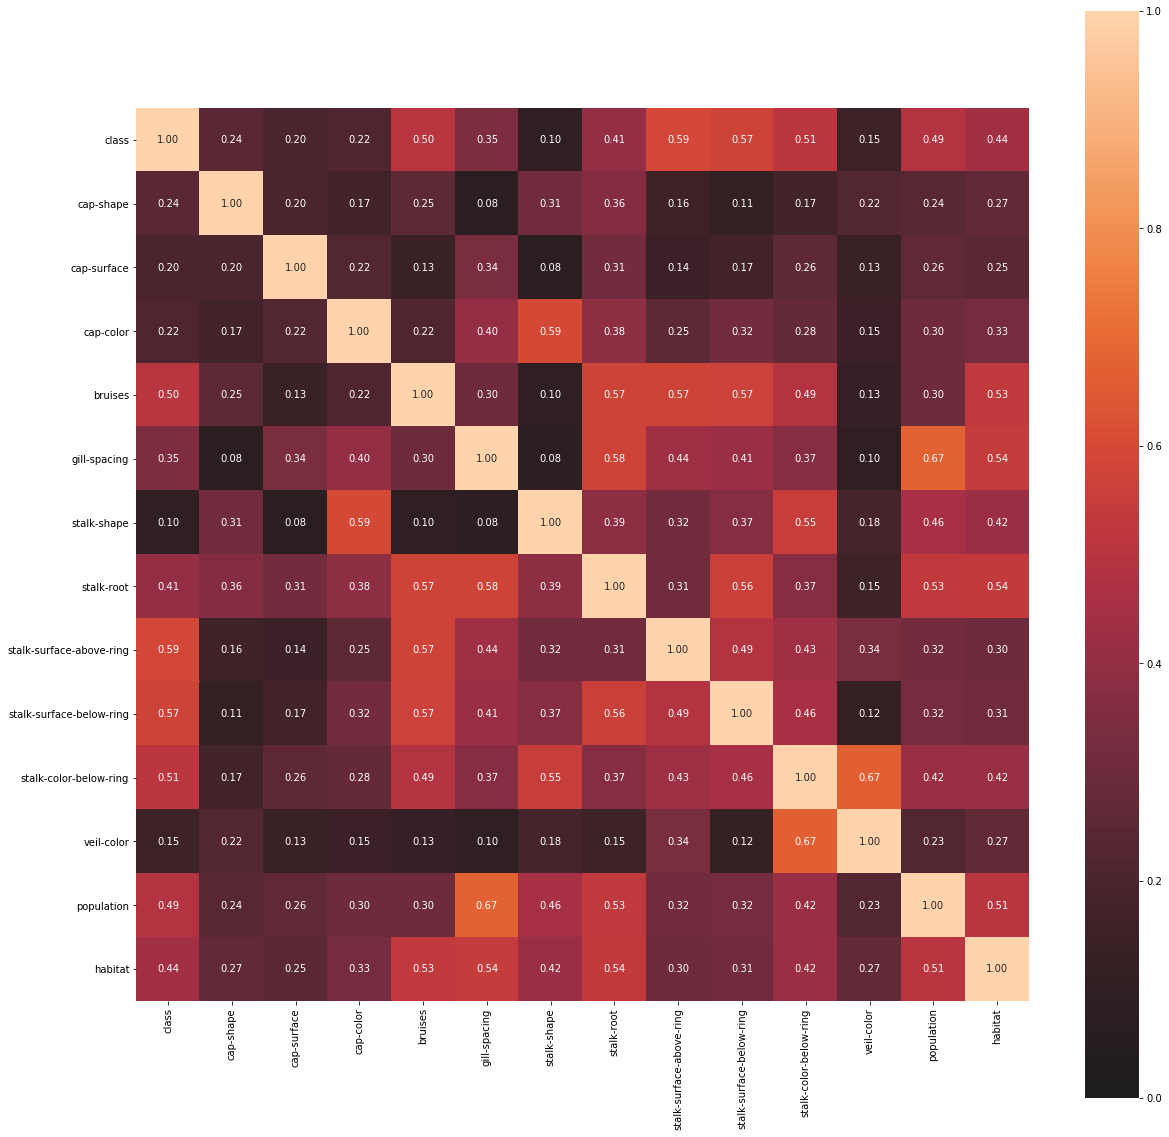

In [11]:
data_corr = data_corr.drop(['odor', 'veil-type', 'gill-attachment', 'stalk-color-above-ring', 'gill-size', 'gill-color', 'ring-type', 'ring-number', 'spore-print-color'], axis=1)

def associations_():
    associations(data_corr,nominal_columns=['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises',
                                            'gill-spacing', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                                            'stalk-surface-below-ring', 'stalk-color-below-ring', 'veil-color',
                                            'population', 'habitat'])
    
plt.rcParams["figure.figsize"]=20,20
associations_()

In [14]:
data_corr_dummies = pd.get_dummies(data_corr.drop(['class'], axis=1))

In [15]:
data_corr_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 65 columns):
cap-shape_b                   8124 non-null uint8
cap-shape_c                   8124 non-null uint8
cap-shape_f                   8124 non-null uint8
cap-shape_k                   8124 non-null uint8
cap-shape_s                   8124 non-null uint8
cap-shape_x                   8124 non-null uint8
cap-surface_f                 8124 non-null uint8
cap-surface_g                 8124 non-null uint8
cap-surface_s                 8124 non-null uint8
cap-surface_y                 8124 non-null uint8
cap-color_b                   8124 non-null uint8
cap-color_c                   8124 non-null uint8
cap-color_e                   8124 non-null uint8
cap-color_g                   8124 non-null uint8
cap-color_n                   8124 non-null uint8
cap-color_p                   8124 non-null uint8
cap-color_r                   8124 non-null uint8
cap-color_u                   8124 non-null

In [18]:
data_corr = pd.concat([data_corr['class'],data_corr_dummies])

In [21]:
data_corr

,0,bruises_f,bruises_t,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,...,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,veil-color_n,veil-color_o,veil-color_w,veil-color_y
0,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
inspect = []
for i in data_corr.columns[1:65]:
    obs = pd.crosstab(data_corr['class'], data_corr[i])
    stat, pval, df, expected = chi2_contingency(obs)
    if pval < 0.05:
        inspect.append(i)

inspect

KeyError: 'class'

In [ ]:
#data_corr = data_corr.drop([''], axis=1)

In [ ]:
#preprocessing numerical
Num_features = data_corr.select_dtypes(include='int64').columns
data_corr[Num_features] = StandardScaler().fit_transform(data_corr[Num_features])
data_corr.head()